# Single channel recordings

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from single_channel_analysis import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Choose the data file you want to analyze

#### Put the .abf files with your recordings in the "data/Single_channels" folder

In [85]:
data_folder = "data/4-Single_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/4-Single_channels


['data/4-Single_channels/2024_06_11_0003.abf',
 'data/4-Single_channels/2025_06_10_0028.abf',
 'data/4-Single_channels/2025_06_10_0052 KM002 gap free 2min.abf',
 'data/4-Single_channels/2025_06_10_0032.abf',
 'data/4-Single_channels/2025_06_10_0027.abf',
 'data/4-Single_channels/2025_06_10_0025.abf',
 'data/4-Single_channels/2025_06_10_0019.abf',
 'data/4-Single_channels/2025_06_10_0057.abf']

Choose which file you want to analyze and copy/paste the file name here:

**If you get an error, make sure you copy/pasted the name correctly (e.g. with both quotation marker, without any commas)**

In [86]:
# data_file = 'data/4-Single_channels/2025_06_10_0052 KM002 gap free 2min.abf'

data_file = 'data/4-Single_channels/2025_06_10_0028.abf'

Now we can load the file and plot the raw data:

Trace('2025_06_10_0028.abf')
Number of sweeps: 1
Points per sweep: 1,500,000
Duration per sweep: 30.000 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage, TTL


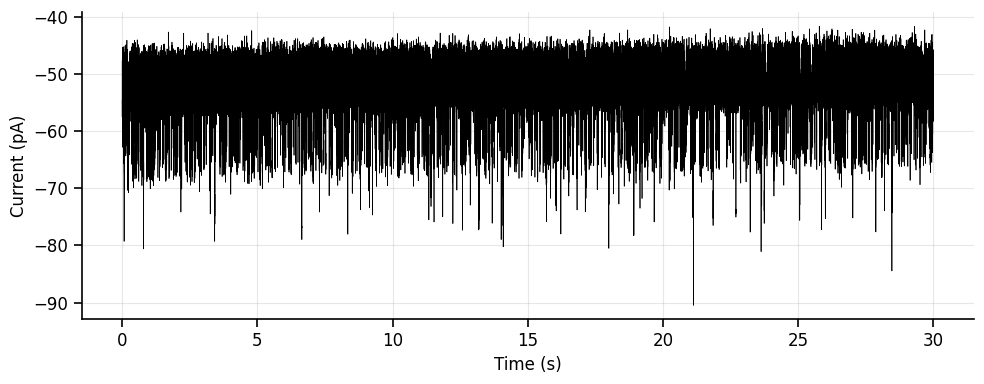

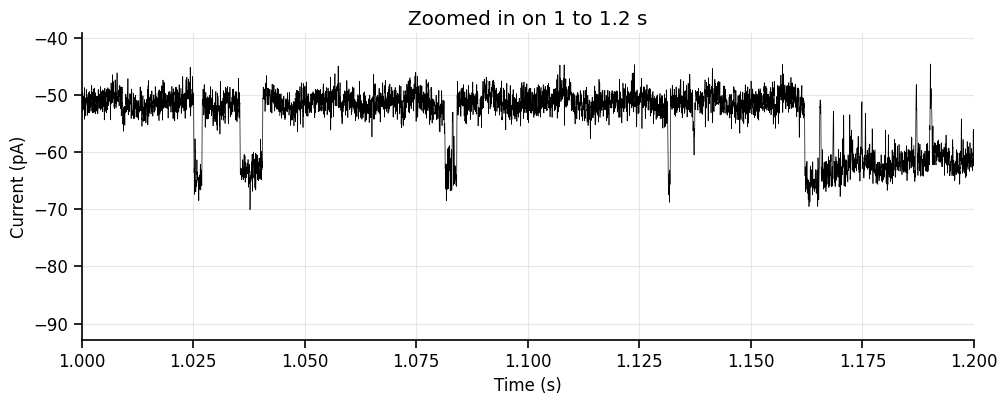

In [87]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 's' # specify seconds (s), or milliseconds (ms)
x_axis_range = (1,1.2) # Here you can set the rage of the x-axis to 'zoom in' on a specific part of the trace (1-2s recommended)

# ----------------------------------------------------------------------------------------------------------------
ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
plt.show()
ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
ax.set_xlim(x_axis_range)
ax.set_title(f'Zoomed in on {x_axis_range[0]} to {x_axis_range[1]} {time_units}')
plt.show()

## 2. Signal processing

### 2.1. Optional: apply highpass / lowpass / bandpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [88]:
apply_filtering = True

You can run this next cell as many times as you want to fine-tune the filtering parameters:

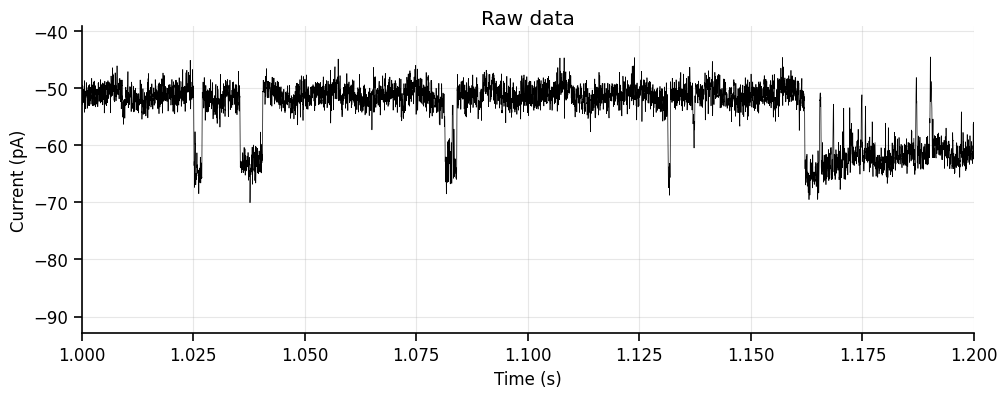

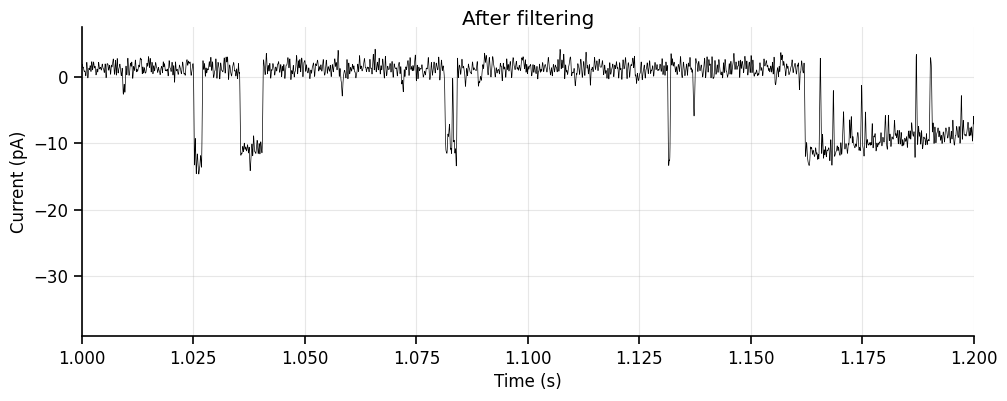

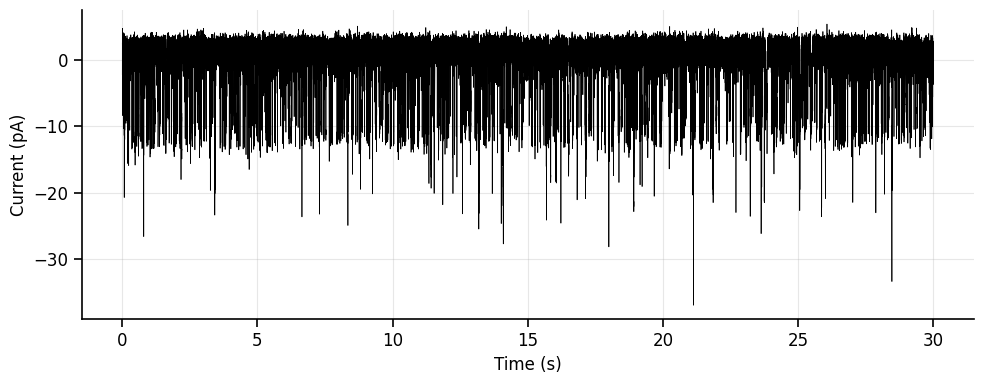

In [89]:
if apply_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 3000) # Choose a value in units of Hz
    
    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

    # Step 4: Highpass filter (removes low-frequency oscillations)
    # ------------------------------------------------------------
    # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # ------------------------------------------------------------

    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False)
    ax.set_xlim(x_axis_range)
    ax.set_title('Raw data', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False)
    ax.set_xlim(x_axis_range)
    ax.set_title('After filtering', y=0.98)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=False)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [90]:
if apply_filtering:
    traces=filtered_traces

### 2.2. Optional: apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [91]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

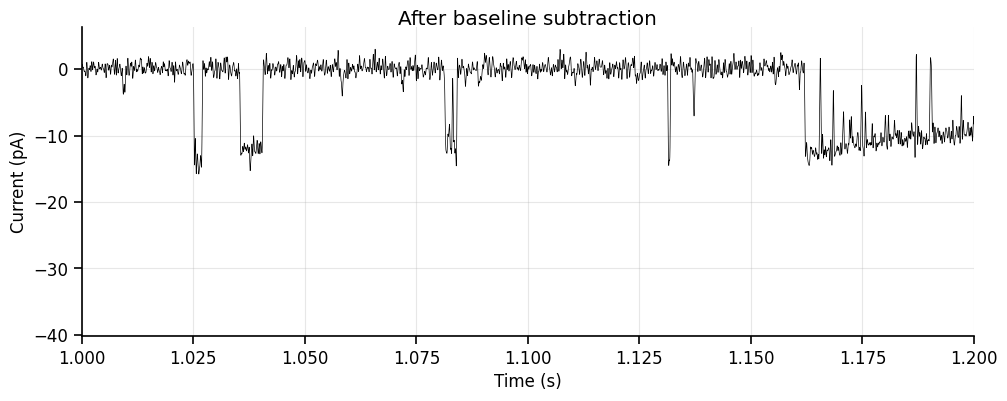

In [92]:
if subtract_baseline:
    # %matplotlib widget
    %matplotlib inline
    traces.current_data = traces.current_data - np.median(traces.current_data)
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_title('After baseline subtraction', y=0.98)
    ax.set_xlim(x_axis_range)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### 2.3. Optional: crop trace (if the edges are not flat)

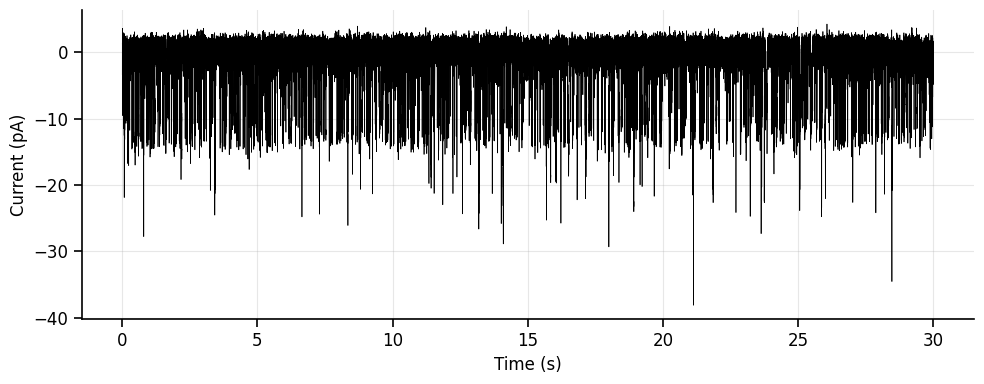

In [93]:
# The markers will define the window where we crop the traces. 'None'= No cropping.
marker_1 = None
marker_2 = None

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax = traces.plot(plot_voltage=False, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
plt.show()

In [94]:
# Apply the crop based on the markers
if marker_1 is not None or marker_2 is not None:
    traces = traces.crop(timepoint=marker_1, time_units=time_units, timepoint_2=marker_2)
    ax = traces.plot(plot_voltage=False, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
    plt.show()

### 3.3. Detect the number of distinct levels (channel opening states)

In [95]:
current_direction = 'inward' # Specify 'inward' or 'outward' current

Using provided mean guesses: [0, 5, 10]

Fitting Gaussian 1/3...
Fitted: mean=-0.173 pA, std=0.831 pA, R²=0.991

Fitting Gaussian 2/3...
Fitted: mean=10.127 pA, std=2.011 pA, R²=0.829

Fitting Gaussian 3/3...
Fitted: mean=2.613 pA, std=1.060 pA, R²=0.869


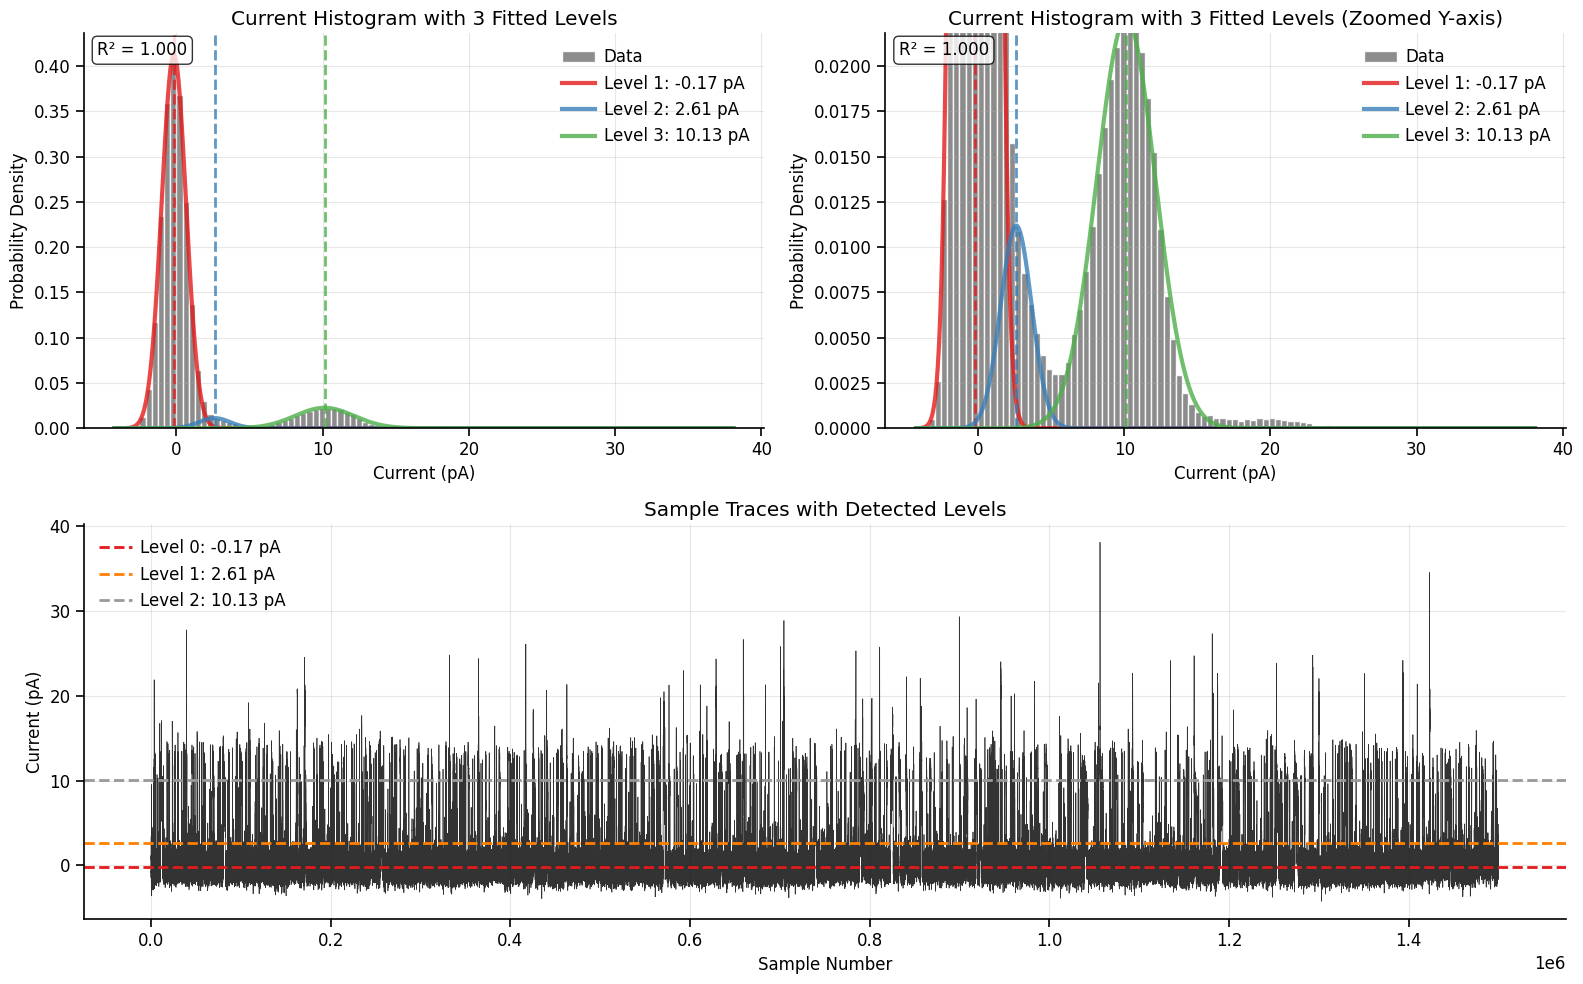


=== ITERATIVE LEVEL DETECTION RESULTS ===
Method: gaussian_subtraction (factor: 1.0)
Detected 3 current levels:
  Level 0: -0.173 pA (individual R²: 0.991)
  Level 1: 2.613 pA (individual R²: 0.869)
  Level 2: 10.127 pA (individual R²: 0.829)
Overall fit quality (R²): 1.000
Standard deviations: ['0.831', '1.060', '2.011']

Baseline level: -0.173 pA
Other Levels: ['2.613', '10.127'] pA


In [96]:
if current_direction == 'inward':
    # Flip the trace (at the moment the idealization only works with positive levels)
    filtered_traces = -traces.current_data

# # Detect levels automatically by fitting Gaussian distributions to the histogram
detected_levels, fit_info = detect_levels_from_histogram(filtered_traces, 
                                                         n_levels=3,  # Specify number of levels (baseline + open levels)
                                                         mean_guesses=[0,5,10],  # Initial guesses for means
                                                         bins=100)

# The baseline will be the lowest detected level
baseline_level = detected_levels[0]
other_levels = detected_levels[1:] 

print(f"\nBaseline level: {baseline_level:.3f} pA")
print(f"Other Levels: {[f'{level:.3f}' for level in other_levels]} pA")

##### The automatic gaussian fit usually fails to detect the highest level correctly.

##### In this case you set it manually based on the extracted Levels above (probably a multiple of the previous level)


In [97]:
baseline_level = -0.173
other_levels = [10.127, 20.2]

### 3.4. Detect channel open/close events and idealize single-channel behavior

In [98]:
# Initialize detector with your filtered traces
detector = MultiLevelEventDetector(filtered_traces, traces.time, traces.sampling_rate)

detector.baseline_level = baseline_level
detector.set_current_levels(other_levels)

Set 2 current levels:
  L1: 10.13 pA
  L2: 20.20 pA
Detection thresholds: ['4.98', '15.16'] pA


/Users/ag1880/github-repos/CSHL_IonChannels2025/CSHL_IonChannels2025/single_channel_analysis.py:629: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  )
/Users/ag1880/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


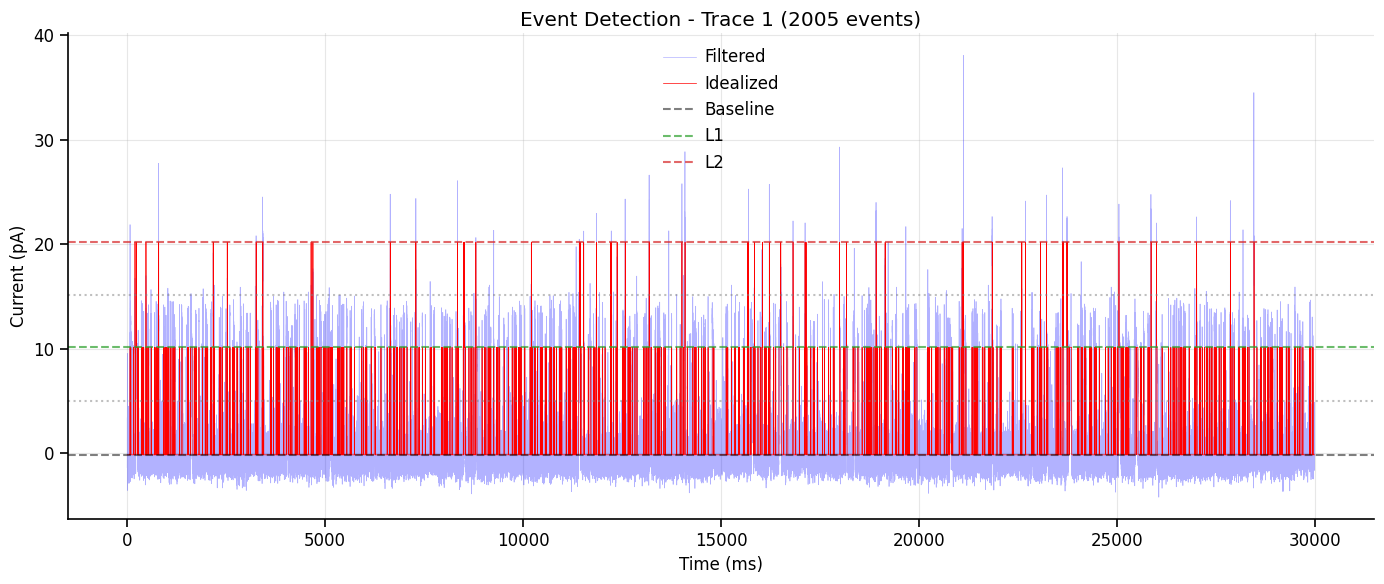

Found 2005 events in trace 1
First few events:
  Event 1: 0.0-8.1 ms, Baseline, 8.14 ms duration
  Event 2: 8.2-59.5 ms, Baseline, 51.38 ms duration
  Event 3: 59.6-70.2 ms, Baseline, 10.66 ms duration
  Event 4: 70.2-70.8 ms, L1, 0.54 ms duration
  Event 5: 70.8-71.2 ms, Baseline, 0.42 ms duration

To process all traces, run: detector.detect_all_events()
To adjust levels, run: detector.set_current_levels([level1, level2, ...])


In [99]:
# Set detection parameters
detector.min_event_duration = 0.3  # ms - adjust based on your channel kinetics

# Test event detection of the first trace
events_trace1, idealized_trace1 = detector.detect_events_single_trace(0, plot_result=True)

# ---------------------------------------------------------------------
# Print the results
print(f"Found {len(events_trace1)} events in trace 1")
if events_trace1:
    print("First few events:")
    for i, event in enumerate(events_trace1[:5]):
        start_ms, end_ms, level_idx, amplitude = event
        level_name = detector.level_names[level_idx-1] if level_idx > 0 else 'Baseline'
        duration_ms = (end_ms - start_ms) * 1000
        print(f"  Event {i+1}: {start_ms*1000:.1f}-{end_ms*1000:.1f} ms, {level_name}, {duration_ms:.2f} ms duration")
print(f"\nTo process all traces, run: detector.detect_all_events()")
print(f"To adjust levels, run: detector.set_current_levels([level1, level2, ...])")


Processing 1 traces...


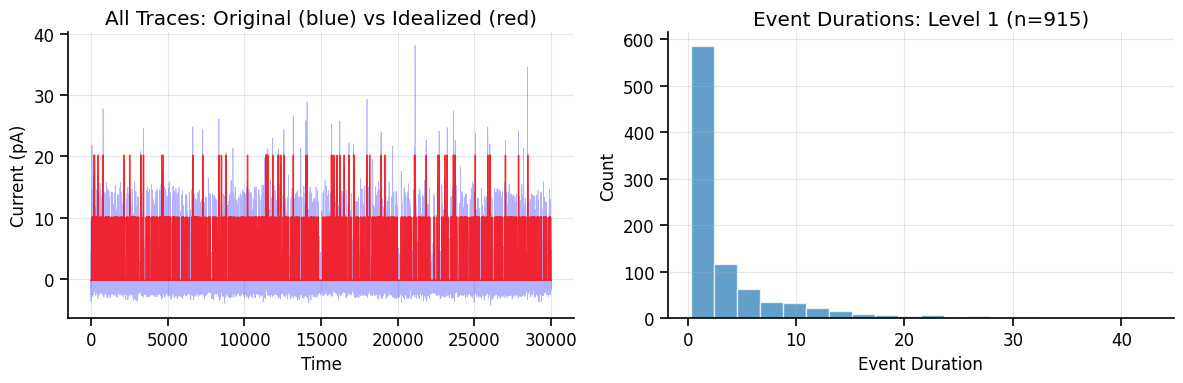

In [100]:
events_all, idealized_traces = detector.detect_all_events(plot_summary=True, duration_hist_bins=20)

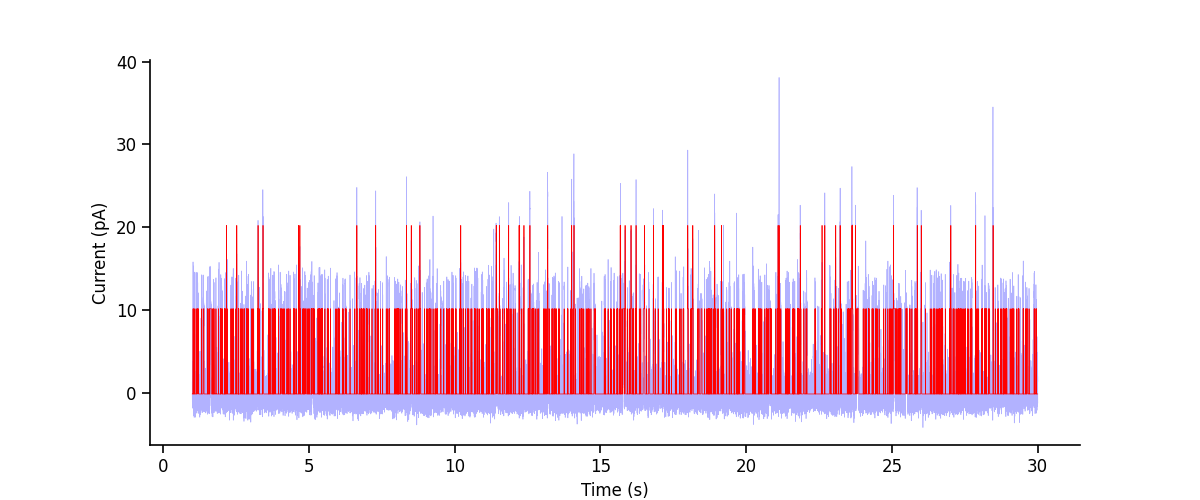

In [101]:
# Zoom in on part of the trace to check if idealization is good
start_time = 1   # in seconds
end_time = 30.      # in seconds

# -----------------------------------------------------------------------------------------------------------------------------------------------
%matplotlib widget
fig, ax = plt.subplots(figsize=(12, 5))
t0 = traces.time[0]
start_idx = time_to_index(start_time-t0, traces.sampling_rate) *1000
end_idx = time_to_index(end_time-t0, traces.sampling_rate) *1000
ax.plot(traces.time[start_idx:end_idx], detector.traces[0, start_idx:end_idx], 'b-', alpha=0.3, linewidth=0.5, label='Filtered')
ax.plot(traces.time[start_idx:end_idx], detector.idealized_traces[0, start_idx:end_idx], 'r-', linewidth=0.5, label='Idealized')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (pA)')
plt.show()


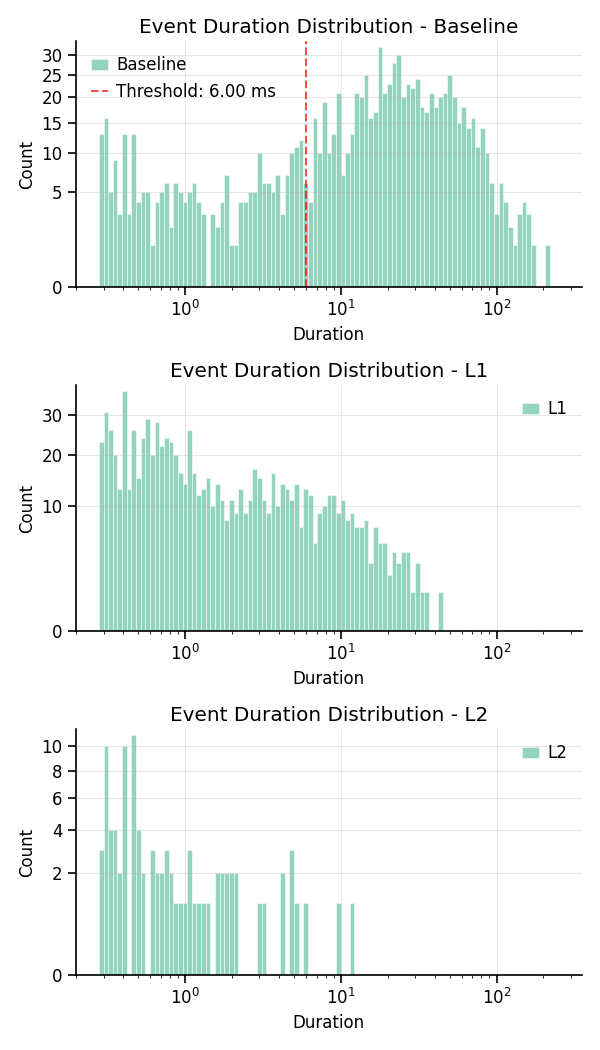

In [102]:
# Based on the histogram of closed durations, determine a threshold for burst separation
closed_threshold = 6  # ms - adjust based on your histogram

durations = detector.plot_duration_histogram(bins=100, threshold=closed_threshold,
                                             fit_gaussian=False,
                                             log_x=True, sqrt_y_scale=True,
                                             separate_plots=True)

Burst Analysis (threshold: 6 ms)
Number of bursts: 546
Mean burst duration: 7.27 ms
Mean Po within bursts: 0.8113


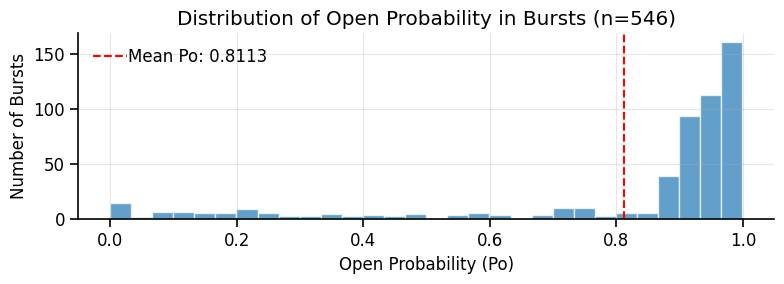

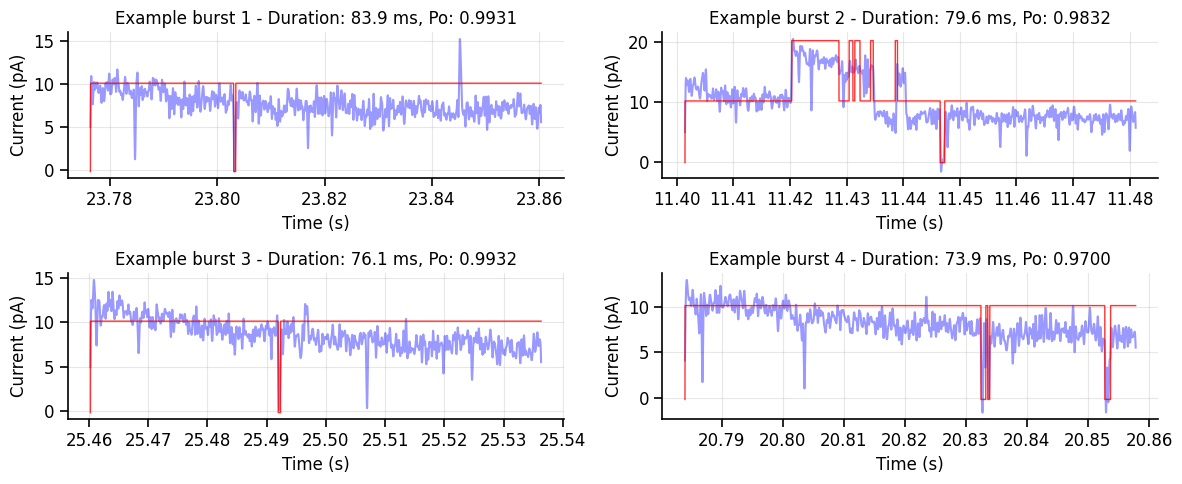

In [103]:
# Analyze bursts
burst_data, burst_summary = detector.analyze_bursts(closed_threshold)

# Plot burst analysis
%matplotlib inline
detector.plot_burst_analysis(burst_data)


# # Print summary statistics
# print(f"Overall Po (across all data): {po_overall:.4f}")
# print(f"Po within bursts: {burst_summary['overall_po_in_bursts']:.4f}")

In [104]:
# Generate comprehensive report
detector.generate_analysis_report()
# Prints everything: Po, mean durations, event counts, etc.

SINGLE-CHANNEL ANALYSIS REPORT

BASIC STATISTICS:
  Number of traces: 1
  Total events detected: 2005
  Events per trace: 2005.0 ± 0.0

CURRENT LEVELS:
  Baseline: -0.17 pA
  L1: 10.13 pA
  L2: 20.20 pA

OPEN PROBABILITY:
  Mean P(open): 0.8113 (81.13%)

EVENT DURATIONS:
  Baseline: 26.63 ± 29.35 ms (median: 17.88 ms, n=997)
  L1: 3.60 ± 5.48 ms (median: 1.14 ms, n=915)
  L2: 1.29 ± 1.87 ms (median: 0.50 ms, n=93)


## Calculate P(open) based on binomial distribution

If we have a good recording, we might be able to confidently say exactly how many channels are in our patch (from the largest open conductance level we see in the current trace). 

For example, there might be exactly 3 discrete conductance levels above baseline, consistent with 1, 2, or 3 BK channels being open. 

If we make a few assumptions, we can use the binomial theorem to calculate the P(open) for a single channel based on the amount of time spend in each conductance level. 

Assuming:
- All channels are identical,
- Each channel is **either open or closed** (no partial conductance states / sublevels)
- Channels behave **independently**
- The system is stationary / at steady state

We can model the number of open channels as a **binomial distribution**:

$$ P(k) = \binom{3}{k} p^k (1 - p)^{3 - k} = \frac{3!}{k!(3-k)!} p^k (1 - p)^{3 - k} $$

where:
- $P(k)$ is the probability of observing $k$ channels open
- $p$ is the open probability of a single channel
- $3$ is the total number of channels (maximum conductance level observed)

By plugging in different values for $k$ from 0 to 3, we get the expected occupancy of each conductance level:
- $ P(0) = (1 - p)^3 $
- $ P(1) = 3p(1 - p)^2 $
- $ P(2) = 3p^2(1 - p) $
- $ P(3) = p^3 $


Now we just need to fit our empirical data to these equations to estimate the single-channel open probability $p$.

We can set this up as a least-squares optimization problem (estimating $p$ by minimizing the squared error between the observed and expected probabilities, and finding the value of $p$ that minimizes the error):

$$ \text{error}(p) = \sum_{k=0}^{3} \left[ \hat{P}(k) - \binom{3}{k} p^k (1 - p)^{3 - k} \right]^2 $$

In [105]:
import numpy as np
from scipy.special import comb  # for binomial coefficients
from scipy.optimize import minimize_scalar

def estimate_p_open(P_obs, n):
    """
    Estimate single-channel open probability p from observed state probabilities.
    
    Parameters:
    - P_obs: array-like of length (m+1), empirical probabilities for k=0 to m open channels
    - n: int, total number of identical, independent channels
    
    Returns:
    - p_estimate: best-fit open probability
    - residuals: array of differences between P_obs and model prediction
    """
    P_obs = np.array(P_obs)
    m = len(P_obs) - 1  # highest observed number of open channels

    def loss(p):
        P_model = [comb(n, k) * (p**k) * ((1 - p)**(n - k)) for k in range(m + 1)]
        return np.sum((P_obs - P_model)**2)

    result = minimize_scalar(loss, bounds=(0, 1), method='bounded')
    p_estimate = result.x
    residuals = P_obs - np.array([comb(n, k) * (p_estimate**k) * ((1 - p_estimate)**(n - k)) for k in range(m + 1)])
    return p_estimate, residuals


# Enter the number of channels in the patch (based on max conductance level observed)
n = 3

# Enter the percentage of time spent in each state
P_obs = np.array([P0, P1, P2, P3])

p, residuals = estimate_p_open(P_obs, n)
print(f"Estimated single-channel open probability: {p:.4f}")
print(f"Residuals: {residuals}")


NameError: name 'P0' is not defined

## Fit a Hidden Markov Model to estimate the channel switching behavior